# Enunciado

The introduction of data science in the field of law and justice is becoming more and more frequent. A well-known example of this is **the COMPAS system** (Correctional offender management profiling for alternative sanctions) which is used in several states in the United States to assess the risk of recidivism of persons in custody. A brief description of the system can be found at https://en.wikipedia.org/wiki/COMPAS_(software).

In this case, it provides a raw dataset with information from assessments (compas-scores.csv file) and legal history for **11 000 cases between years 2013 and 2014** (this is one of the original files used in an independent analysis of the COMPAS system conducted by ProPublica, available on the internet). Although the dataset contains additional information, to resolve the issues raised in this case the following fields are necessary (apart from some fields whose name is self-explanatory):

## Context

- *“compas_screening_date”*: Date in which the evaluation was done.
- *“decile_score”*: Is a number, from 1 to 10, indicating the risk of recidivism in general (the higher the risk, the higher the number).
- v_decile_score "*: Is a number from 1 to 10, potentially different from the previous one, indicating the risk of recidivism in violent crimes. When a case is evaluated in COMPAS, the two scores are generated (among other things).
- *"is_recid"*: Indication of whether the person is a repeat offender (at the time data are collected: there is no information on whether the person is a repeat offender beyond certain dates, and it is important to take this into account to ensure homogeneous comparisons).
- *"r_offense_date "*: Date on which the offense for which the person is considered a repeat offender was committed.
- *"is_violent_recid "*: Indication of whether the person is a repeat offender of a violent crime (the same date considerations as for "is_recid" apply here)".
- *"vr_offense_date "*: Date on which the violent crime was committed that gives rise to the consideration of recidivism.

# Questions
It is asked:

- 1. Load the data and perform an exploratory analysis and assessment of the quality of the data needed for the remainder of the case. Specifically, assess the completeness, validity and timeliness of the data and propose mitigation strategies for potential problems encountered.

- 2. Are the "is_recid" and "is_violent_recid" fields in this dataset adequate to assess the accuracy of the risk estimates generated by the COMPAS system? If not, define and calculate a feature that is.

- 3. The threshold for establishing recidivism preventive measures is 7 and above. Given this threshold, generate a contingency table, explaining which case is considered as "positive" (and, therefore, which are type I errors and type II errors).

- 4. The system assigns, on average, higher risk assessments to men than to women, and to African-Americans than to Caucasians. However, recidivism rates are also higher for these groups, although it is not clear whether the risk assignment is "fair" or not. Show these differences in graphical representations and use them to analyze whether the allocation of assessments is fair or not.

- 5. For which type of risk, general crime or violent crime, does the system have more predictive ability?

NOTE: This case study should be done entirely in Python.

## Import data in Python

### Packages and general overview

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt


Before starting with the resolution of the questions, it is important to note that the data are separated by commas and that it is not necessary to skip lines to enter the header, then we can directly import the file using the *.read_csv()* method.

In [47]:
compas_df = pd.read_csv("compas-scores.csv")
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


### Picking the *DataFrame*

To solve the questions posed as explained in the data we need fewer columns than appear in the whole *DataFrame*, so we can specify the columns we want in other variables and work with a *DataFrame* of smaller size. It will be more comfortable to solve the questions.

The columns that we need are:

- *“compas_screening_date”*
- *“decile_score”*
- *“v_decile_score”*
- *“is_recid”*
- *“r_offense_date”*
- *“is_violent_recid”*
- *“vr_offense_date”*

For question 4 we need some extra variables that are *"sex"* and *"race"*.

In [48]:
compas_reduced = compas_df[["compas_screening_date","decile_score","v_decile_score","is_recid",\
                    "r_offense_date","is_violent_recid","vr_offense_date","sex","race"]]
compas_reduced.head()

,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date,sex,race
0,2013-08-14,1,1,0,NaN,0,NaN,Male,Other
1,2014-12-31,5,2,-1,NaN,0,NaN,Male,Caucasian
2,2013-01-27,3,1,1,2013-07-05,1,2013-07-05,Male,African-American
3,2013-04-14,4,3,1,2013-06-16,0,NaN,Male,African-American
4,2013-01-13,8,6,0,NaN,0,NaN,Male,African-American


## Question 1

Load the data and perform an **exploratory analysis** and data quality assessment required for the remainder of the case. Specifically, assess **data completeness, validity and timeliness** and **propose mitigation strategies for potential problems encountered.**.

### Exploratory Data Analysis

In [49]:
compas_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   compas_screening_date  11757 non-null  object
 1   decile_score           11757 non-null  int64 
 2   v_decile_score         11757 non-null  int64 
 3   is_recid               11757 non-null  int64 
 4   r_offense_date         3703 non-null   object
 5   is_violent_recid       11757 non-null  int64 
 6   vr_offense_date        882 non-null    object
 7   sex                    11757 non-null  object
 8   race                   11757 non-null  object
dtypes: int64(4), object(5)
memory usage: 826.8+ KB


The first thing we see is that the *DataFrame* with which we are going to work has 9 columns, 4 of them are integer numerical while the other 3 are of type object, that is to say datetimes, categorical or strings.

Besides, we can already see that there are some null values in the *Non-Null Count* column.

Let's see how the values are distributed:

In [50]:
compas_reduced.describe()

,decile_score,v_decile_score,is_recid,is_violent_recid
count,11757.000000,11757.000000,11757.000000,11757.000000
mean,4.371268,3.571489,0.253806,0.075019
std,2.877598,2.500479,0.558324,0.263433
min,-1.000000,-1.000000,-1.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000
50%,4.000000,3.000000,0.000000,0.000000
75%,7.000000,5.000000,1.000000,0.000000
max,10.000000,10.000000,1.000000,1.000000


We see that some interesting values are that there are negative values in the columns *"decile_score "*, *"v_decile_score "* and *"is_recid "*. 

In none of the 3 cases this makes sense because of the following:
- *"is_recid "* is a *dummy variable*, i.e. it uses a numeric value 0 or 1 to tell whether or not it belongs to a category. That is, if the person is not or is a recidivist respectively. Therefore, cases with values -1 have no meaning in this column.

- Both *"decile_score "* and *"v_decile_score "* have the same problem and that is that instead of being a *dummy variable* it is a scale that goes from 1 to 10. Therefore, values that are -1 are also meaningless, but in this case by the nature of the variable we can intuit that a negative value, even if erroneous, may have been interpreted as a low value. An *a priori* idea could be to replace those values by a 1.

About the values that are type *object*:

In [51]:
compas_reduced.isna().sum()

compas_screening_date        0
decile_score                 0
v_decile_score               0
is_recid                     0
r_offense_date            8054
is_violent_recid             0
vr_offense_date          10875
sex                          0
race                         0
dtype: int64

We see that we have null values in *"r_offense_rate"* and *"vr_offense_rate"* , but these are dates when people have been repeat offenders, and have been repeat offenders in a violent crime respectively.

**That a value is null here makes sense**, because there may be people who have a criminal record and are not repeat offenders, so it is consistent that there are null values and they do not have to be replaced.

Additionally, we can look at some of the *object* type values to see that they are consistent such as that there are two genders or that the dates are not made up.

In [52]:
compas_reduced["compas_screening_date"].max(),compas_reduced["compas_screening_date"].min()

('2014-12-31', '2013-01-01')

The introduction to COMPAS system have sense. Nevertheless:

In [53]:
compas_reduced[compas_reduced["r_offense_date"].notna()]["r_offense_date"].reset_index(drop=True).max()

'2016-03-29'

In [54]:
compas_reduced[compas_reduced["vr_offense_date"].notna()]["vr_offense_date"].reset_index(drop=True).max()

'2016-03-13'

We see that there are dates that do not belong to the range of the years 2013 and 2014 which does not fit the description of the *DataFrame*.

About the sex and the race:

In [55]:
compas_reduced["sex"].value_counts(), compas_reduced["race"].value_counts()

(sex
 Male      9336
 Female    2421
 Name: count, dtype: int64,
 race
 African-American    5813
 Caucasian           4085
 Hispanic            1100
 Other                661
 Asian                 58
 Native American       40
 Name: count, dtype: int64)

Both the races and sexes of the people listed in the COMPAS registry make sense.

Apart from that, most are of African or Caucasian race and there are very few Chinese and Native Americans. The majority are male.

### Integrity, validity and timeliness

Let us remember these concepts:

- **Integrity**: It refers to having all relevant data available to give it the estimated use. It is ensured in three different characteristics, which are the integrity of the dimensions, of the cases and of the individual variables.

- **Validity**: The validity of the data refers to the rules and syntax defined for them.

- **Up-to-dateness**: How up-to-date the data are.

**Regarding completeness**: The dataset has a lot of variables and options to investigate the information and we have selected the data we needed. In this case, it can be said that we have added as relevant data to those initially suggested by the *DataFrame* the *"sex "* and *"race "* columns that we will use in question 4.

Recall that, although the dates of both violent and non-violent recidivism are missing, they can be missing without problem if the person is not a repeat offender in any type of crime. However, we must change the nature of the data.

**Regarding validity**: Data such as -1 in the *"is_recid "*, *"decile_score "* and *"v_decile_score "* columns need to be fixed. It can also be considered a completeness problem since we do not have a clear way to substitute the information of the *dummy variables*.

On the other hand, in the cases of *"decile_score "* and *"v_decile_score "* we can replace the -1 values by a value between 1 and 10.

**Regarding up-to-dateness**: We have seen that the timing of the acts of recidivism go beyond 2014 when our dataset is limited to those dates so we will either discard those values or we will have to narrow them down to the longest possible date, "2014-12-31".

### Profiling

We take measures to address data integrity, validity and timeliness:

#### Integrity

We replace all the *Nan* with values of type *Not a Datetime* so that they do not give us problems. What we are doing is **profiling the Integrity** of the dataset.

In [ ]:
# For the integrity

compas_reduced["r_offense_date"] = pd.to_datetime(compas_reduced["r_offense_date"], errors= "coerce")
compas_reduced["vr_offense_date"] = pd.to_datetime(compas_reduced["vr_offense_date"], errors= "coerce")

compas_reduced[["r_offense_date","vr_offense_date"]]

C:\Users\Manu\AppData\Local\Temp\ipykernel_10492\3192063223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_reduced["r_offense_date"] = pd.to_datetime(compas_reduced["r_offense_date"], errors= "coerce")
C:\Users\Manu\AppData\Local\Temp\ipykernel_10492\3192063223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_reduced["vr_offense_date"] = pd.to_datetime(compas_reduced["vr_offense_date"], errors= "coerce")


,r_offense_date,vr_offense_date
0,NaT,NaT
1,NaT,NaT
2,2013-07-05,2013-07-05
3,2013-06-16,NaT
4,NaT,NaT
...,...,...
11752,NaT,NaT
11753,2014-10-11,NaT
11754,NaT,NaT
11755,NaT,NaT


#### Validity

Let's first see what all the values of *"is_recid"* mean: As *"is_recid "* tells us if they are recidivists by means of a *dummy variable*, if no dates appear ,for example in the column *"r_offense_date"*, we know that there have been no records of recidivism, and in reality that *-1* should be a 0.

Let's see it:

In [ ]:
neg_is_recid = compas_reduced[compas_reduced["is_recid"] == -1].reset_index()
neg_is_recid["r_offense_date"].notna().sum()

# We can also do:
#neg_is_recid["r_offense_date"].values
# and look at the values in a .txt file

0

Therefore, **since there is not a single recurrence date**, we can conclude that all *-1* were actually 0. 
**This is what we have just done is a Validity Profiling.**

In [58]:
compas_reduced["is_recid"] = compas_reduced["is_recid"].replace(-1,0)
compas_reduced["is_recid"].value_counts()

C:\Users\Manu\AppData\Local\Temp\ipykernel_10492\168551545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_reduced["is_recid"] = compas_reduced["is_recid"].replace(-1,0)


is_recid
0    8054
1    3703
Name: count, dtype: int64

Now that it is clear whether or not they are repeat offenders, we can validate the values by profiling them into values between 1 and 10, which are the possible values that this variable can take. This will affect both the *"decile_score "* column and the *"v_decile_score "* column.

To do this, we are going to see which are or are not repeat offenders, and if they are, either in one category or another, the minimum value that we are going to put in their *score* is going to be between 7 and 10, which is what exercise 3 considers as the **threshold of preventive measures**.

In [59]:
neg_decile_scores = compas_reduced[(compas_reduced["decile_score"] == -1) | (compas_reduced["v_decile_score"] == -1)].reset_index(drop=True)
neg_decile_scores_indexes = compas_reduced[(compas_reduced["decile_score"] == -1) | (compas_reduced["v_decile_score"] == -1)].index
neg_decile_scores

,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date,sex,race
0,2014-10-16,-1,6,1,2015-01-12,0,NaT,Male,African-American
1,2013-11-25,-1,-1,0,NaT,0,NaT,Female,Caucasian
2,2013-05-13,-1,-1,0,NaT,0,NaT,Male,Caucasian
3,2013-04-11,-1,3,1,2014-03-14,0,NaT,Male,Caucasian
4,2013-05-07,-1,-1,0,NaT,0,NaT,Female,Caucasian
5,2013-05-12,-1,1,0,NaT,0,NaT,Female,Caucasian
6,2013-06-21,-1,4,0,NaT,0,NaT,Male,Caucasian
7,2013-09-23,-1,1,0,NaT,0,NaT,Female,Other
8,2013-02-08,-1,5,0,NaT,0,NaT,Male,Caucasian
9,2013-03-12,-1,-1,0,NaT,0,NaT,Male,African-American


In [60]:
# For validity
print(compas_reduced[compas_reduced["decile_score"] == 0].values)
print(compas_reduced[compas_reduced["v_decile_score"] == 0].values)

[]
[]


It is relevant to note that the only values that are not within our range are all -1, but we had to try option 0 because it was not specified in *.describe()*.

If the *"is_recid"* is positive, the prediction is true so putting a score of 7 or more is appropriate in the *"decile_score"* column.
Since there are none who are repeat violent offenders, we will put the mode, mean or median. We will decide this graphically.

In [61]:
print(compas_reduced["decile_score"].mode(), compas_reduced["decile_score"].mean(),compas_reduced["decile_score"].median())

0    1
Name: decile_score, dtype: int64 4.371268180658332 4.0


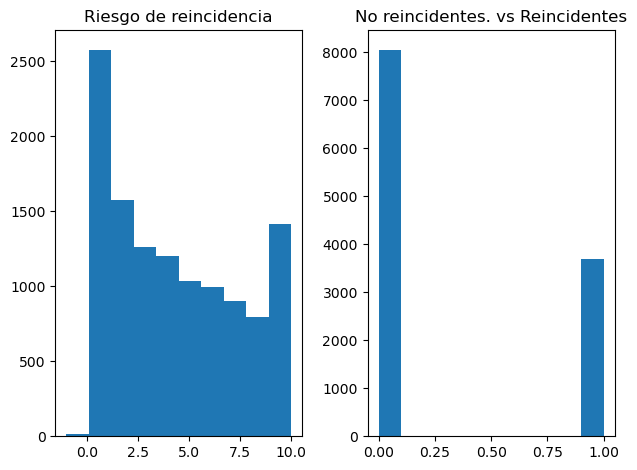

In [62]:
plt.subplot(1,2,1)
plt.hist(x = compas_reduced["decile_score"])
plt.title("Ricidivism risk")

plt.subplot(1,2,2)
plt.hist(x = compas_reduced["is_recid"])
plt.title("Non repeat offenders vs. Repeat offenders")

plt.tight_layout()
plt.show()

The values at end 1 are very numerous, but it would be exaggerated to put the mode as the most appropriate value for the unknown values. This is supported by 2 factors:
- The mean and median are considerably higher than the mode.
- The number of recidivists account for almost half of the cases and we may be ignoring 13 people being recidivists of this subset, which is too many.

Therefore, we will use the median as a replacement (The mode if rounded is the same as the median).
We replace values:

In [63]:
index = 0
for elem in neg_decile_scores["is_recid"]:
    a = np.random.randint(7,11)
    if elem == 0:
        neg_decile_scores.loc[index,"decile_score"] = compas_reduced["decile_score"].median()
        index += 1
        #print("He estado en 1") AUX
    elif elem == 1:
        neg_decile_scores.loc[index,"decile_score"] = a
        index += 1
        #print("He estado en 2") AUX

For the case of the *v_decile_scores* we can see how they are distributed as we have done before:

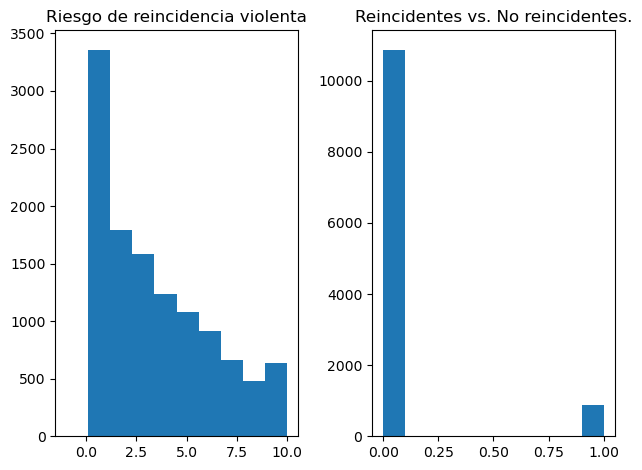

In [64]:
plt.subplot(1,2,1)
plt.hist(x = compas_reduced["v_decile_score"])
plt.title("Risk of violent recidivism")

plt.subplot(1,2,2)
plt.hist(x = compas_reduced["is_violent_recid"])
plt.title("Non repeat offenders vs. Repeat offenders")

plt.tight_layout()
plt.show()

In [65]:
compas_reduced["v_decile_score"].median()

3.0

Here again, we do not impute by mode but by median. 
Note that despite the difference in the number of individuals who are or are not repeat offenders, what we are doing is to impute preventive measures, i.e. in this type 1 error **we do not limit the freedom of the individual, because we do not lock him up, but we establish measures that protect citizens. Therefore, it is more convenient to make a mistake of this type than to be too lax**. It is quite another thing to consider imprisoning the individual.

Knowing this, it is convenient to charge the median in this case:

In [66]:
index = 0
for elem in neg_decile_scores["v_decile_score"]:
    if elem == -1:
        neg_decile_scores.loc[index,"v_decile_score"] = compas_reduced["v_decile_score"].median()
        index += 1
        #print("Have been in 1") AUX
    else:
        index += 1
        #print("Have been in 2") AUX

This leaves us with the subset of the *DataFrame* that had the invalid values, now transformed. We implement it in the *DataFrame* we are working on, *compas_reduced*.

In [67]:
#neg_decile_scores.iloc[1]

In [68]:
indice_reseteado = 0
for ind_original in neg_decile_scores_indexes:
    compas_reduced.iloc[ind_original] = neg_decile_scores.iloc[indice_reseteado]
    indice_reseteado += 1

#compas_reduced.iloc[528] #To compare results for iter

#### Validity summary
- Negative values of *"decile_score"* and *"v_decile_score"* scores are removed according to median and mode, respectively.
- All *"is_recid "* that were -1 were actually 0 because there were no dates with recidivism records for any of those cases.

#### Up-to-dateness

The up-to-dateness problem we have is that the dates are more up to date than what the dataset says. We can see that the dates as of 2015 are as follows:

- For the set *"vr_offense_date "*:

In [69]:
mascara = compas_reduced['vr_offense_date'].notna() & (compas_reduced['vr_offense_date'] > "2014-12-31")
compas_reduced[mascara]

,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date,sex,race
12,2013-11-04,3,5,1,2015-01-06,1,2015-01-06,Male,Caucasian
36,2013-05-06,3,3,1,2013-11-06,1,2015-02-23,Male,African-American
39,2014-10-24,10,6,1,2015-08-15,1,2015-08-15,Male,African-American
115,2014-07-21,7,8,1,2015-04-05,1,2015-04-05,Male,Caucasian
121,2013-02-21,10,9,1,2013-04-17,1,2015-04-24,Male,African-American
...,...,...,...,...,...,...,...,...,...
11651,2013-03-21,2,4,1,2014-03-20,1,2015-03-16,Male,Other
11663,2013-12-13,5,3,1,2015-10-08,1,2015-10-08,Male,Caucasian
11680,2013-04-10,9,6,1,2015-10-22,1,2015-10-22,Male,African-American
11683,2013-12-10,9,9,1,2014-07-12,1,2015-12-20,Male,African-American


- Para el conjunto *"r_offense_date"*:

In [70]:
mascara = compas_reduced['r_offense_date'].notna() & (compas_reduced['r_offense_date'] > "2014-12-31")
compas_reduced[mascara]

,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date,sex,race
12,2013-11-04,3,5,1,2015-01-06,1,2015-01-06,Male,Caucasian
23,2014-11-15,3,2,1,2015-04-27,0,NaT,Male,Caucasian
26,2014-10-16,2,3,1,2015-01-05,0,NaT,Male,Caucasian
28,2014-10-16,10,6,1,2015-01-12,0,NaT,Male,African-American
39,2014-10-24,10,6,1,2015-08-15,1,2015-08-15,Male,African-American
...,...,...,...,...,...,...,...,...,...
11698,2014-06-06,4,6,1,2016-01-12,0,NaT,Male,African-American
11729,2014-01-08,3,3,1,2016-01-13,0,NaT,Male,Caucasian
11736,2014-03-28,6,4,1,2015-01-07,0,NaT,Male,African-American
11738,2014-07-01,4,4,1,2015-04-22,0,NaT,Female,Caucasian


We also see that most of the data indicate that the dataset is highly old-fashioned:

In [71]:
print((compas_reduced['vr_offense_date']<= "2014-12-31").value_counts(),(compas_reduced['r_offense_date']<= "2014-12-31").value_counts())

vr_offense_date
False    11277
True       480
Name: count, dtype: int64 r_offense_date
False    9403
True     2354
Name: count, dtype: int64


We should not change this data by proximity as it represents a huge set of our dataset and would bias it too much. However, if convenient these data can be useful, simply separating the dataset by years will give us extra information. Also, all the dates have consistent values so they do not look like the product of an error.

This is good because instead of being "erroneous" data, they are new data that have been added to the dataset, and we can use them to extract more information. 

If for whatever reason we want to work only with 2013 and 2014 data, we work with a smaller auxiliary *DataFrame* for those years.

In this way, I leave the **Up-to-dateness** issues unmodified for the advantage they bring to our dataset.

---------------------

### Numeric Exploratory Data Analysis

Regarding data distribution:

In [72]:
compas_reduced.describe()

,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date
count,11757.000000,11757.000000,11757.000000,3703,11757.000000,882
mean,4.378583,3.573190,0.314961,2014-08-27 11:06:31.790440192,0.075019,2014-10-29 08:04:53.877551104
min,1.000000,1.000000,0.000000,2013-01-03 00:00:00,0.000000,2013-01-28 00:00:00
25%,2.000000,1.000000,0.000000,2014-01-14 00:00:00,0.000000,2014-03-31 06:00:00
50%,4.000000,3.000000,0.000000,2014-08-27 00:00:00,0.000000,2014-11-19 00:00:00
75%,7.000000,5.000000,1.000000,2015-04-04 00:00:00,0.000000,2015-06-25 18:00:00
max,10.000000,10.000000,1.000000,2016-03-29 00:00:00,1.000000,2016-03-13 00:00:00
std,2.871999,2.498728,0.464520,NaN,0.263433,NaN


- Most people (at least 50%) who are involved in any type of crime are not repeat offenders, as the median *"is_recid "* is 0. However, we know that **between 25% and 50% are repeat offenders in non-violent crimes**, as the 75th percentile is repeat offenders in this type of crime.

- In turn, we see that at least 75% of those who have committed crimes have not reoffended in violent crimes, **but between 0 and less than 25% have reoffended in violent crimes** as indicated by the 75th percentile which is 0 for the variable *"is_violent_recid "*.

To find more precise values it would be necessary to investigate other percentiles and solve for the -1 values in the *"is_recid "* column.

However, we know that recidivists in violent crimes are 7.5019% of the total, since the mean in a *dummy variable* only becomes positive if the value is one, i.e. there are:

In [73]:
11757 * np.mean([compas_reduced["is_violent_recid"]])

881.9999999999999

There are 882 people that are repeat offenders in violent crimes.

Regarding the *"decile_score "* and *"v_decile_score "*, we see that there are at least 25% who are going to need recidivism preventive measures, but only for non-violent offenses.

---------------------------------------------

## Pregunta 2

### Approach

- 2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.


Si *"is_recid"* y *"is_violent_recid"* son buenas *features* para calcular la precisión de las estimaciones, podemos separar el dataset en 2 casos, cada uno con dos datasets:

- Caso de comparación de *"is_recid"*.
    - Los que no son reincidentes de ningún tipo.
    - Los que son reincidentes sin violencia junto a los que son reincidentes con violencia.
- Caso de comparación de *"is_violent_recid"*.
    - Los que no son reincidentes de ningún tipo junto a la reincidentes sin violencia.
    - Los que son reincidentes con violencia.

In [74]:
no_reincidentes = compas_reduced[(compas_reduced["is_recid"]==0) & (compas_reduced["is_violent_recid"]==0)]
reinci_sin_violencia = compas_reduced[(compas_reduced["is_recid"]==1) & (compas_reduced["is_violent_recid"]==0)]
reincidente_violento = compas_reduced[(compas_reduced["is_recid"]==1) & (compas_reduced["is_violent_recid"]==1)]

In [87]:
is_recid_0 = no_reincidentes.copy()
is_recid_1 = pd.concat([reinci_sin_violencia, reincidente_violento])

is_violent_recid_0 = pd.concat([no_reincidentes, reinci_sin_violencia])
is_violent_recid_1 = reincidente_violento.copy()

Ahora, comparamos los valores según las columnas de predicción, es decir las columnas *"decile_score"* y *"v_decile_score"*.

### Campo *"is_recid"*

¿Qué características de los individuos nos pueden resultar útiles para saber si son o no reincidentes en delitos sin violencia? Vamos a ver primero cómo de efectivo resulta este método de separación de *"is_recid"*:

In [88]:
is_recid_0["decile_score"].value_counts()

decile_score
1     2222
2     1225
3      921
4      830
5      664
6      587
7      503
9      409
8      407
10     286
Name: count, dtype: int64

In [89]:
is_recid_1["decile_score"].value_counts()

decile_score
6     406
7     397
9     394
8     389
4     382
5     370
1     355
2     347
3     338
10    325
Name: count, dtype: int64

Graficamos los datos para tener una mejor idea de cómo se distribuyen.

c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


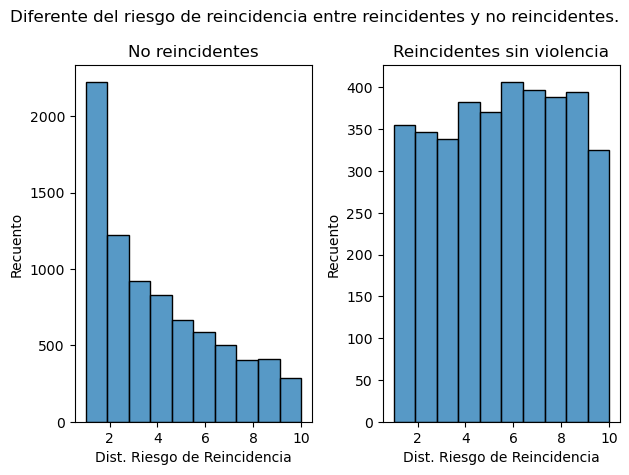

In [90]:
plt.subplot(1,2,1)
sns.histplot(data = is_recid_0, x ="decile_score", bins = 10)
plt.xlabel("Dist. Riesgo de Reincidencia")
plt.ylabel("Recuento")
plt.title("No reincidentes")

plt.subplot(1,2,2)
sns.histplot(data = is_recid_1, x ="decile_score", bins = 10)
plt.xlabel("Dist. Riesgo de Reincidencia")
plt.ylabel("Recuento")
plt.title("Reincidentes sin violencia")

plt.suptitle("Diferencia del riesgo de reincidencia entre reincidentes y no reincidentes.")
plt.tight_layout()
plt.show()

Entre los no reincidentes es razonable pero vemos que aquellos que son reincidentes deben tener puntuaciones mucho más altas, mínimo de 7 para comenzar a tener medidas preventivas. De este modo, se llega a la conclusión de que **no es una buena *feature* para clasificar la precisión de las estimaciones de violencia.**

Habría que buscar una alternativa.

### Campo *"is_violent_recid"*

Para este caso, tenemos que comparar los individuos que están separados en casos donde no ha habido violencia con casos en los que ha habido violencia. Por tanto habrá un dataset de individuos que sean reincidentes junto a no reincidentes, y otro de reincidentes violentos.

In [91]:
is_violent_recid_0["v_decile_score"].value_counts()

decile_score
1     2495
2     1506
3     1189
4     1128
5      954
6      907
7      798
9      696
8      693
10     509
Name: count, dtype: int64

In [92]:
is_violent_recid_1["v_decile_score"].value_counts()

v_decile_score
3     119
6     116
1     113
4      95
5      88
2      85
9      82
7      81
8      69
10     34
Name: count, dtype: int64

c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Manu\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


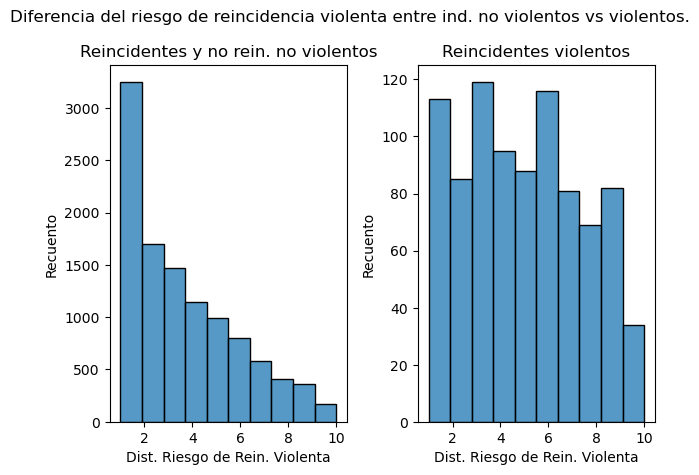

In [97]:
plt.subplot(1,2,1)
sns.histplot(data = is_violent_recid_0, x ="v_decile_score", bins = 10)
plt.xlabel("Dist. Riesgo de Rein. Violenta")
plt.ylabel("Recuento")
plt.title("Reincidentes y no rein. no violentos")

plt.subplot(1,2,2)
sns.histplot(data = is_violent_recid_1, x ="v_decile_score", bins = 10)
plt.xlabel("Dist. Riesgo de Rein. Violenta")
plt.ylabel("Recuento")
plt.title("Reincidentes violentos")

plt.suptitle("Diferencia del riesgo de reincidencia violenta entre ind. no violentos vs violentos.")
plt.tight_layout()
plt.show()

Vemos que los que ya han reincidido tambien tienen valores que son muy bajos lo cual no casa con la vida real. También hay que volver a buscar un criterio que sea más apropiado para clasificar el riesgo de reincidencia violenta.

-----------------------

### Análisis del conjunto de reincidencia

Veamos si podemos encontrar más características que sean propias de aquellos que tienen *"decile_score"* altos.

In [109]:
high_decile_score = compas_reduced[compas_reduced["decile_score"] >= 7]
low_decile_score = compas_reduced[compas_reduced["decile_score"] < 7]

print(high_decile_score["sex"].value_counts(), low_decile_score["sex"].value_counts())
print(high_decile_score["race"].value_counts(), low_decile_score["race"].value_counts())

sex
Male      2620
Female     490
Name: count, dtype: int64 sex
Male      6716
Female    1931
Name: count, dtype: int64
race
African-American    2219
Caucasian            665
Hispanic             153
Other                 56
Native American       12
Asian                  5
Name: count, dtype: int64 race
African-American    3594
Caucasian           3420
Hispanic             947
Other                605
Asian                 53
Native American       28
Name: count, dtype: int64


Aquí con un simple vistazo vemos ya diferencias tanto en la raza como en el género de las personas que aparecen en los registros. Vamos a visualizarlos:

Por raza, vemos que los Afro-Americanos aparecen en muchos más registros que los demás. 
Despues van los Caucásicos, los hispanos, otras razas, y los asiáticos son los únicos que parecen menos conflictivos que el resto.

** PONER HISTOGRAMA POR RAZA**